In [123]:
import tensorflow as tf
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import argparse
import imutils
import os
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
import random

Fetching MLO files

In [3]:
def get_path_list(dir_path):
    path_list = list(set(map(lambda x: x if x[-7:] == "MLO.png" else "",os.listdir(dir_path))))
    path_list = list(filter(None, path_list))
    return [dir_path+i for i in path_list]

dir_name = ["output","clean"]
data_split = ["train","test","val"]
cancer_type = ["BENIGN","MALIGNANT"]
combined_path = []
cimbined_clean_path = []

for i in data_split:
    for j in cancer_type:
        path = f"{dir_name[0]}/{i}/{j}/"
        combined_path += get_path_list(path) 

for i in data_split:
    for j in cancer_type:
        path = f"{dir_name[1]}/{i}/{j}/"
        cimbined_clean_path += get_path_list(path) 

In [23]:
cimbined_clean_path[0]

'clean/train/BENIGN/P_01565_RIGHT_MLO.png'

Creating a binary mask

In [97]:
def create_binary_mask_opencv(grayscale_image, threshold=127):
    _, binary_mask = cv2.threshold(grayscale_image, threshold, 255, cv2.THRESH_BINARY)

    return binary_mask

grayscale_image = cv2.imread(cimbined_clean_path[0], cv2.IMREAD_GRAYSCALE)
binary_mask = create_binary_mask_opencv(grayscale_image, threshold=15)


(1920, 1080)

Displaying the mask

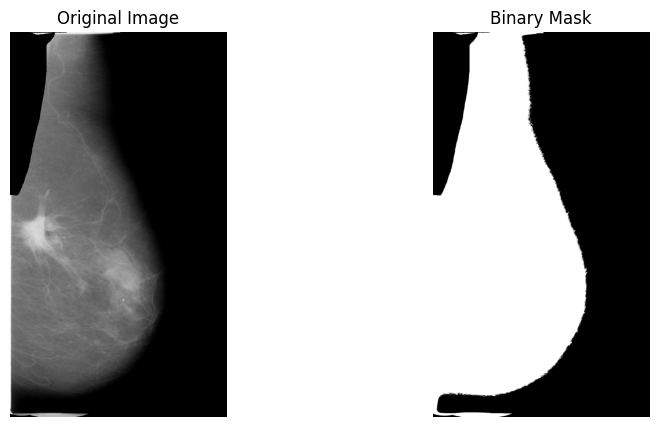

In [18]:
def display_images(original_image, mask):
    plt.figure(figsize=(10, 5))  
    plt.subplot(1, 2, 1)  
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')  

    plt.subplot(1, 2, 2)  
    plt.imshow(mask, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')  

    plt.show()

display_images(grayscale_image,binary_mask)

Saving the mask

In [92]:
def save_mask_opencv(mask, filename,ext):
    os.makedirs(f'masks/{ext}', exist_ok=True)
    binary_mask_image = Image.fromarray(mask)
    
    filepath = os.path.join(f'masks/{ext}', filename)
    
#     binary_mask_image.save(filepath, format='PNG')
    cv2.imwrite(filepath, mask)

for files in cimbined_clean_path:
    image = Image.open(files)
    grayscale_image = image.convert('L')
    grayscale_array = np.array(grayscale_image)
    grayscale_array = np.expand_dims(grayscale_array, axis=-1)
    binary_mask = create_binary_mask_opencv(grayscale_array, threshold=15)
    save_mask_opencv(binary_mask, files.split('/')[-1],files.split('/')[1])

In [30]:
def save_img_opencv(image,filename,ext):
    os.makedirs(f'image/{ext}', exist_ok=True)
    filepath = os.path.join(f'image/{ext}', filename)
    cv2.imwrite(filepath, image)
    

for files in combined_path:
    grayscale_image = cv2.imread(files, cv2.IMREAD_GRAYSCALE)
    save_img_opencv(grayscale_image, files.split('/')[-1],files.split('/')[1])

Preparing the data

Training Data

In [115]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'image/train/'
mask_path = 'masks/train/'


train_ids = next(os.walk(TRAIN_PATH))[-1]


X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

/var/folders/85/y769y1816h3d4d7tll4c47nm0000gn/T/ipykernel_2214/3307410409.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [131]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    mask_image = mask_path + id_
    img = cv2.imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img 
    
    mask = Image.open(mask_image)
    mask = image.convert('L')
    mask = np.expand_dims(mask, axis=-1)
    mask = np.array(mask)[:,:,:IMG_CHANNELS] 

    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask   

Validation data

In [130]:
VAL_PATH = 'image/val/'
mask_val_path = 'masks/val/'

val_ids = next(os.walk(VAL_PATH))[-1]

x_val = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_val = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Resizing Validation data images and masks')
for n, id_ in tqdm(enumerate(val_ids), total=len(val_ids)):   
    path = VAL_PATH + id_
    mask_image = mask_val_path + id_
    img = cv2.imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_val[n] = img 
    
    mask = Image.open(mask_image)
    mask = image.convert('L')
    mask = np.expand_dims(mask, axis=-1)
    mask = np.array(mask)[:,:,:IMG_CHANNELS] 

    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    y_val[n] = mask  

/var/folders/85/y769y1816h3d4d7tll4c47nm0000gn/T/ipykernel_2214/422544503.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_val = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


Resizing Validation data images and masks


100%|█████████████████████████████████████████| 139/139 [00:28<00:00,  4.95it/s]


Testing data

In [142]:
TEST_PATH = 'image/test/'
mask_test_path = 'masks/test/'

test_ids = next(os.walk(TEST_PATH))[-1]

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

sizes_test = []

print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    mask_image = mask_test_path + id_
    
    img = cv2.imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
    mask = Image.open(mask_image)
    mask = image.convert('L')
    mask = np.expand_dims(mask, axis=-1)
    mask = np.array(mask)[:,:,:IMG_CHANNELS] 

    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_test[n] = mask 
    

/var/folders/85/y769y1816h3d4d7tll4c47nm0000gn/T/ipykernel_2214/1104551780.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


Resizing test images


100%|█████████████████████████████████████████| 191/191 [00:38<00:00,  5.00it/s]


U-Net Model

In [134]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 128, 128, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 16)         448       ['lambda_1[0][0]']            
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 16)         0         ['conv2d_19[0][0]']           
                                                                                            

 conv2d_34 (Conv2D)          (None, 64, 64, 32)           9248      ['dropout_16[0][0]']          
                                                                                                  
 conv2d_transpose_7 (Conv2D  (None, 128, 128, 16)         2064      ['conv2d_34[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_7 (Concatenate  (None, 128, 128, 32)         0         ['conv2d_transpose_7[0][0]',  
 )                                                                   'conv2d_20[0][0]']           
                                                                                                  
 conv2d_35 (Conv2D)          (None, 128, 128, 16)         4624      ['concatenate_7[0][0]']       
                                                                                                  
 dropout_1

In [135]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_segmentation.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_data = (x_val,y_val), batch_size=16, epochs=25, callbacks=callbacks)


Epoch 1/25
33/33 [==============================] - 14s 392ms/step - loss: 0.6433 - accuracy: 0.5663 - val_loss: 0.5025 - val_accuracy: 0.7328
Epoch 2/25
33/33 [==============================] - 13s 386ms/step - loss: 0.2534 - accuracy: 0.9088 - val_loss: 0.0923 - val_accuracy: 0.9658
Epoch 3/25
33/33 [==============================] - 13s 387ms/step - loss: 0.0420 - accuracy: 0.9832 - val_loss: 0.0891 - val_accuracy: 0.9642
Epoch 4/25
33/33 [==============================] - 13s 398ms/step - loss: 0.0182 - accuracy: 0.9927 - val_loss: 0.0674 - val_accuracy: 0.9814
Epoch 5/25
33/33 [==============================] - 14s 413ms/step - loss: 0.0066 - accuracy: 0.9975 - val_loss: 0.0951 - val_accuracy: 0.9830
Epoch 6/25
33/33 [==============================] - 13s 405ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.3493 - val_accuracy: 0.9666


Dice coefficient

In [146]:
def dice_score(Y_test, preds_test, smooth=1e-6):
    Y_test_flat = Y_test.flatten()
    preds_test_flat = preds_test.flatten()
    
    intersection = np.sum(Y_test_flat * preds_test_flat)
    dice = (2. * intersection + smooth) / (np.sum(Y_test_flat) + np.sum(preds_test_flat) + smooth)
    
    return dice

dice = dice_score(Y_test, preds_test)
print(f"Dice coefficient: {dice}")


Dice coefficient: 0.9645466492076034
